In [1]:
# default_exp viseme_tabular.model

# Tabular model

> Tabular model definition and helper functions.

I wanted to try some "light" options for inference - i.e. we want to be able to train models with fastai/pytorch but then run the trained models on machines without GPU, using as little resources as possible.

For the tabular model, we'll implement forward pass only "Modules" in numpy, saving and loading trained weights as numpy arrays. For me, this is an interesting thing to build - but for "real" projects, we'd probably want to use onnx (which we do for image models).

In [2]:
#export
from expoco.core import *
from pathlib import Path
import numpy as np
import json

In [3]:
from expoco.viseme_tabular.data import read_processed_dataset, get_image_path
import matplotlib.pyplot as plt
import pandas as pd
import tempfile, shutil

## Saving model state

In [4]:
#export
def save_state_dict(path, state_dict, **training_info):
    "Saves `state_dict` and `training_info` to a new model directory"
    path, model_id = Path(path), now()
    output_path = path/f'model_{model_id}'
    output_path.mkdir()
    file_name = output_path/'state_dict.npz'
    metadata = dict(path=path_to_str(path), output_path=path_to_str(output_path), 
                    file_name=path_to_str(file_name), training_info=training_info)
    with open(output_path/'metadata.json', 'w') as f: json.dump(metadata, f, indent=2)
    np.savez(file_name, **{k:state_dict[k].detach().cpu().numpy() for k in state_dict})
    with np.load(file_name) as _: pass # check that we didn't need to pickle
    return output_path

- `path` directory to create the new model directory in
    - usually, this will be processed data directory; e.g. `data/viseme_tabular_dataset_20211116_113131/processed_20211117_200746`
    - which would create something like `data/viseme_tabular_dataset_20211116_113131/processed_20211117_200746/model_20211117_201151`
- `state_dict` a pytorch state_dict - i.e. a dictionary of tensors
- `training_info` any info needed to repeat the model training (can also include model metrics etc)

In [5]:
temp_path = Path(tempfile.mkdtemp())
try:
    output_path = save_state_dict(temp_path, {})
    assert output_path.parent == temp_path
    assert (output_path/'metadata.json').is_file()
    assert (output_path/'state_dict.npz').is_file()
finally:
    shutil.rmtree(temp_path)

## Loading model state

In [6]:
#export
def load_state_dict(path):
    "Load `state_dict.npz` from `path` (a model directory)"
    return np.load(Path(path)/'state_dict.npz')

`load_state_dict` returns a `NpzFile`, which should be used as a context manager (so that the npz file we opened gets closed).

In [7]:
temp_path = Path(tempfile.mkdtemp())
class MockTensor:
    def __init__(self, arr):
        self.arr = arr
    def detach(self):
        return self
    def cpu(self):
        return self
    def numpy(self):
        return self.arr
try:
    a = np.ones((2,3))
    b = np.zeros((3,2))
    output_path = save_state_dict(temp_path, dict(a=MockTensor(a), b=MockTensor(b)))
    with load_state_dict(output_path) as state_dict:
        assert np.allclose(a, state_dict['a'])
        assert np.allclose(b, state_dict['b'])
finally:
    shutil.rmtree(temp_path)

# Inference only `numpy` model

We need to write a little code so that we can run inference using a previously saved state dict.

In [8]:
#export 
class NpBatchNorm1d:
    "Applies Batch Normalization"
    # https://github.com/pytorch/pytorch/blob/420b37f3c67950ed93cd8aa7a12e673fcfc5567b/aten/src/ATen/native/Normalization.cpp#L61-L126
    def __init__(self, weight, bias, running_mean, running_var, num_batches_tracked=None):
        self.weight, self.bias = weight, bias
        self.running_mean, self.running_std = running_mean, np.sqrt(running_var + 1e-5)
    def __call__(self, x):
        x = x - self.running_mean
        x = x / self.running_std
        x = x * self.weight
        x = x + self.bias
        return x

In [9]:
#export 
class NpLinear:
    "Applies a linear transformation"
    def __init__(self, weight, bias=None):
        self.weight, self.bias = weight.T, bias
    def __call__(self, x):
        x = x @ self.weight
        if self.bias is not None:
            x = x + self.bias
        return x

In [10]:
#export 
class NpReLU:
    "Applies element wise max of x and zero"
    def __call__(self, x):
        return np.maximum(x, 0)

In [11]:
#export 
class NpModel:
    "A sequential module container"
    def __init__(self, *modules):
        self.modules = modules
    def __call__(self, x):
        for module in self.modules:
            x = module(x)
        return x

In [12]:
#export
def get_class_count(model):
    return model.modules[-1].weight.shape[1]

In [13]:
#export
def load_tabular_model(path):
    "Load `state_dict.npz` from `path` (a model directory) and create a tabular model"
    state_dict = load_state_dict(path)
    # TODO: this only works for the model config we used ... TODO: make it a bit more generic
    return NpModel(NpBatchNorm1d(**get_dict_subset(state_dict, 'bn_cont')),
                   NpLinear(**get_dict_subset(state_dict, 'layers.0.0')),
                   NpReLU(),
                   NpBatchNorm1d(**get_dict_subset(state_dict, 'layers.0.2')),
                   NpLinear(**get_dict_subset(state_dict, 'layers.1.0')),
                   NpReLU(),
                   NpBatchNorm1d(**get_dict_subset(state_dict, 'layers.1.2')),
                   NpLinear(**get_dict_subset(state_dict, 'layers.2.0')))

In [14]:
np_model = load_tabular_model('test/data/viseme_tabular_dataset/processed/model')
assert 4 == get_class_count(np_model)

In [15]:
#export 
def create_confusion_matrix(model, df, cont_names, y_name):
    "Confusion matrix as a numpy array"
    class_count = get_class_count(model)
    confusion_matrix = np.zeros([class_count,class_count], dtype=int)
    output = model(df[cont_names].to_numpy())
    preds = np.argmax(output, axis=1)
    _class_to_id = dict(AH=0, EE=1, NO_EXPRESSION=2, OO=3) # TODO: train tabular model, save class map in metadata
    targets = _data[y_name].apply(lambda v: _class_to_id[v]).to_list()
#     targets = df[y_name].to_numpy(dtype=int)
    for p,t in zip(preds, targets):
        confusion_matrix[t][p]+=1
    return confusion_matrix

In [16]:
_metadata, _data, _stats = read_processed_dataset('test/data/viseme_tabular_dataset/processed', False)
confusion_matrix = create_confusion_matrix(np_model, _data, _data.columns[:-1], _data.columns[-1])
confusion_matrix

array([[0, 5, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 3, 1],
       [0, 0, 0, 5]])

In [17]:
#export
def plot_confusion_matrix(model, df, cont_names, y_name):
    "Plot a confusion matrix using matplotlib"
    confusion_matrix = create_confusion_matrix(model, df, cont_names, y_name)
    class_count = get_class_count(model) # class_count might not be the same as len(class_ids)
    class_ids = [0,1,2,3] # TODO: train tabular model, save class map in metadata
    class_labels = ['AH', 'EE', 'NO_EXPRESSION', 'OO']
    fig, ax = plt.subplots(figsize=(9,9))
    ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.8)
    # ax.xaxis.set_ticks_position('bottom') # must be after matshow
    ax.yaxis.set_label_position('right')
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')
    plt.title('Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    tick_marks = np.arange(class_count)
    plt.xticks(tick_marks, class_labels[:class_count], rotation=90)
    plt.yticks(tick_marks, class_labels[:class_count], rotation=0)
    plt.show()

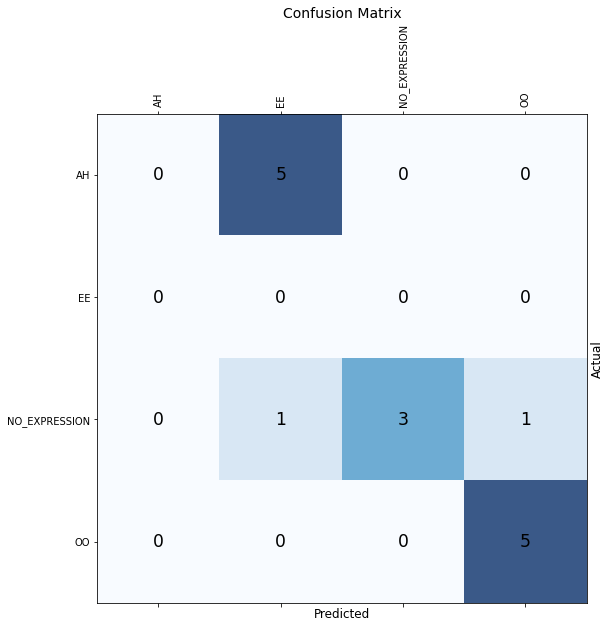

In [18]:
plot_confusion_matrix(np_model, _data, _data.columns[:-1], _data.columns[-1])

In [19]:
#export 
def get_idxs_of_interest(model, df, cont_names, y_name, target_of_interest, pred_of_interest):
    "Indeces in `df` where `df[y_name]` had `target_of_interest` but the model predicted `pred_of_interest`"
    class_labels = ['AH', 'EE', 'NO_EXPRESSION', 'OO'] # TODO: train tabular model, save class map in metadata
    output = model(df[cont_names].to_numpy())
    preds = np.argmax(output, axis=1)
    _class_to_id = dict(AH=0, EE=1, NO_EXPRESSION=2, OO=3) # TODO: train tabular model, save class map in metadata
    targets = _data[y_name].apply(lambda v: _class_to_id[v]).to_numpy()
#     targets = df[y_name].to_numpy()
    idxs = []
    print('target_of_interest', class_labels[target_of_interest],
          'pred_of_interest', class_labels[pred_of_interest])
    print('overall accuracy', (targets==preds).sum() / len(targets))
    _filter = targets==target_of_interest
    print('accuracy for target_of_interest',(targets[_filter]==preds[_filter]).sum() / _filter.sum())
    for i, (p,t) in enumerate(zip(preds,targets)):
        if t==target_of_interest and p==pred_of_interest:
            idxs.append(i)
    return idxs


- `target_of_interest` class ID of the target we're interested in
- `pred_of_interest` class ID of the prediction we're interested in

In [20]:
idxs = get_idxs_of_interest(np_model, _data, _data.columns[:-1], _data.columns[-1], 2, 3)

target_of_interest NO_EXPRESSION pred_of_interest OO
overall accuracy 0.5333333333333333
accuracy for target_of_interest 0.6


We can `df.iloc[idxs]` and look at the rows that the model saw.

We can also use `get_image_path` &darr; to get `img_path`, input values before processing etc

In [21]:
pd.DataFrame(dict(idx=idxs, image_path=[str(get_image_path('test/data/viseme_tabular_dataset/processed', i))[44:] for i in idxs]))

,idx,image_path
0,2,.jpeg


In [22]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01a_camera_capture.ipynb.
Converted 10a_viseme_tabular_identify_landmarks.ipynb.
Converted 10b_viseme_tabular_data.ipynb.
Converted 10d_viseme_tabular_model.ipynb.
Converted 10e_viseme_tabular_train_model.ipynb.
Converted 10f_viseme_tabular_test_model.ipynb.
Converted 11b_viseme_image_data.ipynb.
Converted 11d_viseme_image_model.ipynb.
Converted 11e_viseme_image_train_model.ipynb.
Converted 11f_viseme_image_test_model.ipynb.
Converted 20a_gui_capture_command.ipynb.
Converted 20a_gui_main.ipynb.
Converted 70_cli.ipynb.
Converted index.ipynb.
Converted project_lifecycle.ipynb.
